<a href="https://colab.research.google.com/github/imaizumi0302/study-notes/blob/main/pytorch-advanced/1_1_load_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 「第1章 画像分類」の準備ファイル

- 本ファイルでは、第1章で使用するフォルダの作成とファイルのダウンロードを行います。

In [ ]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git
%cd pytorch_advanced/
%cd 1_image_classification


Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 552, done.
remote: Total 552 (delta 0), reused 0 (delta 0), pack-reused 552 (from 1)
Receiving objects: 100% (552/552), 17.89 MiB | 19.83 MiB/s, done.
Resolving deltas: 100% (302/302), done.
/content/pytorch_advanced
/content/pytorch_advanced/1_image_classification


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu


In [ ]:
!pip install tqdm


In [ ]:
import os
import urllib.request
import zipfile

In [ ]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "/content/pytorch_advanced/1_image_classification/data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)


In [ ]:
# ImageNetのclass_indexをダウンロードする
# Kerasで用意されているものです
# https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

In [ ]:
# 1.3節で使用するアリとハチの画像データをダウンロードし解凍します
# PyTorchのチュートリアルで用意されているものです
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIPファイルを読み込み
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

    # ZIPファイルを消去
    os.remove(save_path)

In [ ]:
# パッケージのimport
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [ ]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [ ]:
# PyTorchのバージョン確認
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.9.0+cpu
Torchvision Version:  0.24.0+cpu


In [ ]:
# 学習済みのVGG-16モデルをロード
# 初めて実行する際は、学習済みパラメータをダウンロードするため、実行に時間がかかります

# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)
net.eval()  # 推論モードに設定

# モデルのネットワーク構成を出力
print(net)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 140MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 入力画像の前処理クラスを作成

In [ ]:
# 入力画像の前処理のクラス
class BaseTransform():
    """
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  # 短い辺の長さがresizeの大きさになる
            transforms.CenterCrop(resize),  # 画像中央をresize × resizeで切り取り
            transforms.ToTensor(),  # Torchテンソルに変換
            transforms.Normalize(mean, std)  # 色情報の標準化
        ])

    def __call__(self, img):
        return self.base_transform(img)

#以下のcall関数が、Composeクラスの中に存在するため、base_transformというインスタンスに直接imgを引数として与えて呼び出すと、このcallが実行される。
#このComposeクラス内の引数のResizeからNormalizeまでが順次呼び出される。
#そのResizeからNormalizeまでの各クラスもcallを持っているため、その各クラス内のcallを順次実行し、変換された画像が出力される。

# def __call__(self, img):
#     for t in self.transforms:
#         img = t(img)   # ← ここで Resizeインスタンス(img)
#     return img





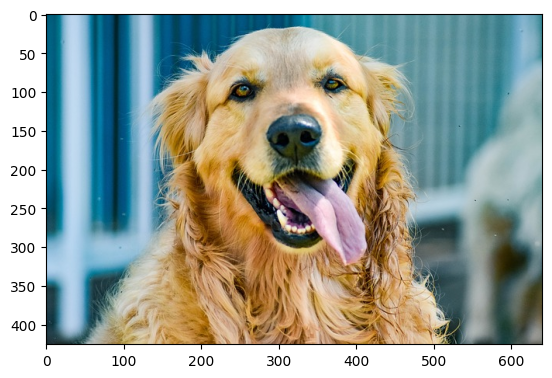

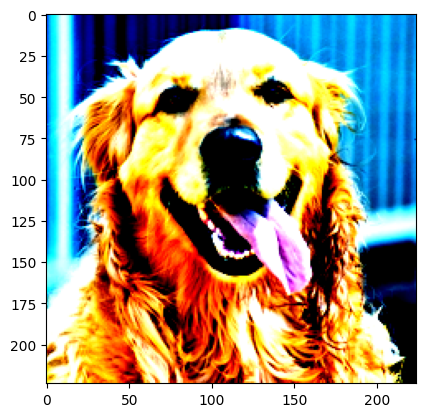

In [ ]:
# 画像前処理の動作を確認

# 1. 画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

#Basetransformのインスタンスを作成、引数にresizeとmeanとstdを与える
transform = BaseTransform(resize, mean, std)
#Basetransformのインスタンスを直接呼び出し、画像を引数に与える。Basetransformの中に__call__関数があるので、これが実行される。
img_transformed = transform(img)  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


# 出力結果からラベルを予測する後処理クラスを作成

In [ ]:
import json

In [ ]:
# ILSVRCのラベル情報をロードし辞書型変数を生成します
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [ ]:
# 出力結果からラベルを予測する後処理クラス
class ILSVRCPredictor():
    """
    ILSVRCデータに対するモデルの出力からラベルを求める。

    Attributes
    ----------
    class_index : dictionary
            クラスindexとラベル名を対応させた辞書型変数。
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        確率最大のILSVRCのラベル名を取得する。

        Parameters
        ----------
        out : torch.Size([1, 1000])
            Netからの出力。

        Returns
        -------
        predicted_label_name : str
            最も予測確率が高いラベルの名前
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name

# 学習済みVGGモデルで手元の画像を予測

In [ ]:
# ILSVRCのラベル情報をロードし辞意書型変数を生成します
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

# ILSVRCPredictorのインスタンスを生成します
predictor = ILSVRCPredictor(ILSVRC_class_index)

# 入力画像を読み込む
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # [高さ][幅][色RGB]

# 前処理の後、バッチサイズの次元を追加する
transform = BaseTransform(resize, mean, std)  # 前処理クラス作成
img_transformed = transform(img)  # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze_(0)  # torch.Size([1, 3, 224, 224])

# モデルに入力し、モデル出力をラベルに変換する
out = net(inputs)  # torch.Size([1, 1000])
result = predictor.predict_max(out)

# 予測結果を出力する
print("入力画像の予測結果：", result)

入力画像の予測結果： golden_retriever


In [ ]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)


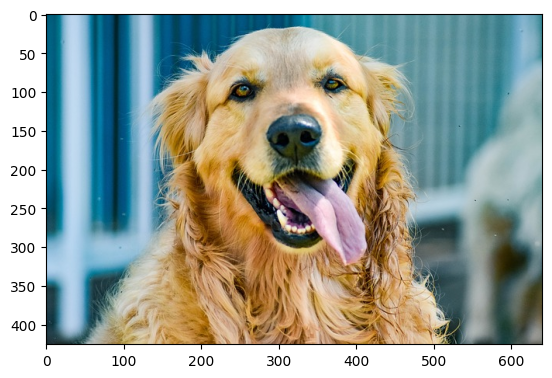

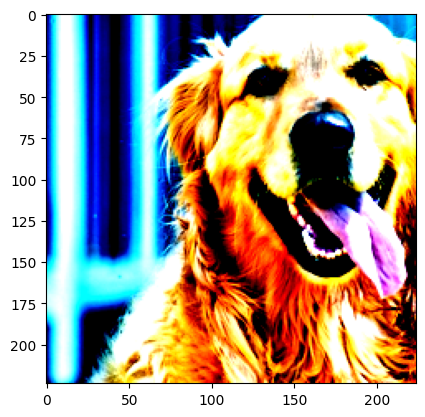

In [ ]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [ ]:
# アリとハチの画像へのファイルパスのリストを作成する


def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。

    Parameters
    ----------
    phase : 'train' or 'val'
        訓練データか検証データかを指定する

    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list


./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/bees/2495722465_879acf9d85.jpg',
 './data/hymenoptera_data/train/bees/1295655112_7813f37d21.jpg',
 './data/hymenoptera_data/train/bees/473618094_8ffdcab215.jpg',
 './data/hymenoptera_data/train/bees/465133211_80e0c27f60.jpg',
 './data/hymenoptera_data/train/bees/196658222_3fffd79c67.jpg',
 './data/hymenoptera_data/train/bees/3074585407_9854eb3153.jpg',
 './data/hymenoptera_data/train/bees/129236073_0985e91c7d.jpg',
 './data/hymenoptera_data/train/bees/2364597044_3c3e3fc391.jpg',
 './data/hymenoptera_data/train/bees/2959730355_416a18c63c.jpg',
 './data/hymenoptera_data/train/bees/354167719_22dca13752.jpg',
 './data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg',
 './data/hymenoptera_data/train/bees/2801728106_833798c909.jpg',
 './data/hymenoptera_data/train/bees/2486746709_c43cec0e42.jpg',
 './data/hymenoptera_data/train/bees/174142798_e5ad6d76e0.jpg',
 './data/hymenoptera_data/train/bees/457457145_5f86eb7e9c.jpg',
 './data/hymenoptera_data/train/

In [ ]:
# アリとハチの画像のDatasetを作成する


class HymenopteraDataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # ラベルを数値に変更する
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
1


# DataLoaderを作成

In [ ]:
# ミニバッチのサイズを指定
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)


torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 0])


# ネットワークモデルの作成する

In [ ]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)

# VGG16の最後の出力層の出力ユニットをアリとハチの2つに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


# 損失関数を定義

In [ ]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定

In [ ]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[ 0.0069, -0.0119,  0.0149,  ..., -0.0089, -0.0150,  0.0019],
        [ 0.0146,  0.0055, -0.0155,  ...,  0.0104, -0.0068,  0.0149]],
       requires_grad=True), Parameter containing:
tensor([-0.0132,  0.0152], requires_grad=True)]


In [ ]:
# 最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

# 学習・検証を実施

In [ ]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測


                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


In [ ]:
# 学習・検証を実行する
num_epochs=2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
-------------


100%|██████████| 5/5 [01:42<00:00, 20.60s/it]


val Loss: 0.8577 Acc: 0.3725
Epoch 2/2
-------------


100%|██████████| 8/8 [02:24<00:00, 18.03s/it]


train Loss: 0.5779 Acc: 0.6461


100%|██████████| 5/5 [01:29<00:00, 17.94s/it]

val Loss: 0.1587 Acc: 0.9542
